<a href="https://colab.research.google.com/github/TasnimJahan/IDT/blob/main/Semi_supervised_Parkinson's_disease_detection_with_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:


# Navigate to your dataset folder in Google Drive
import os
os.chdir('/content/drive/MyDrive/MS shadat sir/parkinson dataset/For semi-supervised')

# Load your dataset
data = pd.read_csv('cp_pd_speech_features.csv')


In [ ]:

# Define features and labels
X = data.drop(columns=['class'])
y = data['class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into 80% labeled and 20% unlabeled
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_scaled, y, test_size=0.20, stratify=y, random_state=42)

# Further split the labeled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.20, random_state=42)


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Dimensions
input_dim = 100  # Latent vector size
feature_dim = X_train.shape[1]  # Dimension of the input features

# Create generator and discriminator
generator = Generator(input_dim, feature_dim)
discriminator = Discriminator(feature_dim)

# Set up optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()


In [ ]:
def train_gan(generator, discriminator, optimizer_g, optimizer_d, criterion, num_epochs=50, batch_size=32):
    for epoch in range(num_epochs):
        for _ in range(len(X_train) // batch_size):
            # Create random noise
            noise = torch.randn(batch_size, 100)

            # Generate fake data
            fake_data = generator(noise)

            # Prepare real data
            real_data = torch.FloatTensor(X_train[np.random.randint(0, X_train.shape[0], batch_size)])

            # Labels for real and fake data
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            # Train Discriminator
            optimizer_d.zero_grad()
            output_d_real = discriminator(real_data)
            loss_d_real = criterion(output_d_real, real_labels)

            output_d_fake = discriminator(fake_data.detach())
            loss_d_fake = criterion(output_d_fake, fake_labels)

            loss_d = loss_d_real + loss_d_fake
            loss_d.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            output_g = discriminator(fake_data)
            loss_g = criterion(output_g, real_labels)
            loss_g.backward()
            optimizer_g.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')
train_gan(generator, discriminator, optimizer_g, optimizer_d, criterion, num_epochs=10, batch_size=32)


Epoch [1/10], Loss D: 1.1033, Loss G: 0.7220
Epoch [2/10], Loss D: 1.0235, Loss G: 0.7290
Epoch [3/10], Loss D: 0.8978, Loss G: 0.7218
Epoch [4/10], Loss D: 0.9091, Loss G: 0.6976
Epoch [5/10], Loss D: 0.8623, Loss G: 0.6837
Epoch [6/10], Loss D: 0.9369, Loss G: 0.7181
Epoch [7/10], Loss D: 0.8306, Loss G: 0.7515
Epoch [8/10], Loss D: 0.7897, Loss G: 0.8009
Epoch [9/10], Loss D: 0.7166, Loss G: 0.8192
Epoch [10/10], Loss D: 0.7689, Loss G: 0.8184


In [ ]:
def generate_synthetic_data(generator, num_samples=1000):
    noise = torch.randn(num_samples, 100)
    synthetic_data = generator(noise).detach().numpy()
    return synthetic_data

synthetic_data = generate_synthetic_data(generator, num_samples=1000)


In [ ]:
# Combine real and synthetic data
combined_X = np.vstack((X_train, synthetic_data))
combined_y = np.hstack((y_train.values, np.ones(synthetic_data.shape[0])))  # Assign class 1 to synthetic data

# Split the combined dataset into training and validation sets
X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(combined_X, combined_y, test_size=0.2, random_state=42)

print(f'Combined training set shape: {X_train_combined.shape}, Combined validation set shape: {X_val_combined.shape}')


Combined training set shape: (1186, 754), Combined validation set shape: (297, 754)


## ***`Training the Classification Model:`***
After the GAN has generated synthetic data, a separate classification model is trained using this synthetic data along with the original labeled data.

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Assuming binary classification
        )

    def forward(self, x):
        return self.model(x)

# Initialize and train the model
input_dim = X_train_combined.shape[1]
classification_model = SimpleNN(input_dim)

# Define optimizer and loss function
optimizer = optim.Adam(classification_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# # Training function for classification model
# def train_classification_model(model, X_train, y_train, num_epochs=50, batch_size=32):
#     model.train()
#     for epoch in range(num_epochs):
#         indices = np.arange(X_train.shape[0])
#         np.random.shuffle(indices)

#         for start_idx in range(0, len(indices), batch_size):
#             end_idx = min(start_idx + batch_size, len(indices))
#             batch_idx = indices[start_idx:end_idx]

#             X_batch = torch.FloatTensor(X_train[batch_idx])
#             y_batch = torch.LongTensor(y_train[batch_idx])

#             optimizer.zero_grad()
#             outputs = model(X_batch)
#             loss = criterion(outputs, y_batch)
#             loss.backward()
#             optimizer.step()

#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Train the classification model
# train_classification_model(classification_model, X_train_combined, y_train_combined, num_epochs=50, batch_size=32)


from sklearn.metrics import f1_score, accuracy_score

def train_classification_model(model, X_train, y_train, num_epochs=50, batch_size=32):
    model.train()
    accuracy_list = []
    f1_list = []

    for epoch in range(num_epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)

        for start_idx in range(0, len(indices), batch_size):
            end_idx = min(start_idx + batch_size, len(indices))
            batch_idx = indices[start_idx:end_idx]

            X_batch = torch.FloatTensor(X_train[batch_idx])
            y_batch = torch.LongTensor(y_train[batch_idx])

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Calculate accuracy and F1 score
        with torch.no_grad():
            val_outputs = model(torch.FloatTensor(X_val_combined))
            _, predicted = torch.max(val_outputs.data, 1)
            acc = accuracy_score(y_val_combined, predicted)
            f1 = f1_score(y_val_combined, predicted, average='weighted')
            accuracy_list.append(acc)
            f1_list.append(f1)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}')

    return accuracy_list, f1_list

# Train the classification model and capture accuracy and F1 scores
accuracy_list, f1_list = train_classification_model(classification_model, X_train_combined, y_train_combined, num_epochs=50, batch_size=32)


Epoch [1/50], Loss: 0.3861, Accuracy: 0.9327, F1 Score: 0.9337
Epoch [2/50], Loss: 0.6165, Accuracy: 0.9461, F1 Score: 0.9461
Epoch [3/50], Loss: 0.0995, Accuracy: 0.9360, F1 Score: 0.9365
Epoch [4/50], Loss: 0.0167, Accuracy: 0.9428, F1 Score: 0.9412
Epoch [5/50], Loss: 0.0001, Accuracy: 0.9428, F1 Score: 0.9412
Epoch [6/50], Loss: 0.0013, Accuracy: 0.9495, F1 Score: 0.9481
Epoch [7/50], Loss: 0.0169, Accuracy: 0.9495, F1 Score: 0.9491
Epoch [8/50], Loss: 0.0000, Accuracy: 0.9495, F1 Score: 0.9491
Epoch [9/50], Loss: 0.0033, Accuracy: 0.9461, F1 Score: 0.9452
Epoch [10/50], Loss: 0.0000, Accuracy: 0.9495, F1 Score: 0.9491
Epoch [11/50], Loss: 0.0005, Accuracy: 0.9495, F1 Score: 0.9491
Epoch [12/50], Loss: 0.0000, Accuracy: 0.9495, F1 Score: 0.9491
Epoch [13/50], Loss: 0.0000, Accuracy: 0.9495, F1 Score: 0.9491
Epoch [14/50], Loss: 0.0000, Accuracy: 0.9495, F1 Score: 0.9491
Epoch [15/50], Loss: 0.0017, Accuracy: 0.9495, F1 Score: 0.9491
Epoch [16/50], Loss: 0.0000, Accuracy: 0.9495, F1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Evaluate the model
def evaluate_model(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val)
        outputs = model(X_val_tensor)
        _, predicted = torch.max(outputs.data, 1)

    accuracy = accuracy_score(y_val, predicted)
    f1 = f1_score(y_val, predicted)
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:\n', classification_report(y_val, predicted))
    print('Confusion Matrix:\n', confusion_matrix(y_val, predicted))

# Evaluate the model on the validation set
evaluate_model(classification_model, X_val_combined, y_val_combined)

Validation Accuracy: 94.95%
F1 Score: 0.9723
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.70      0.72        27
         1.0       0.97      0.97      0.97       270

    accuracy                           0.95       297
   macro avg       0.85      0.84      0.84       297
weighted avg       0.95      0.95      0.95       297

Confusion Matrix:
 [[ 19   8]
 [  7 263]]


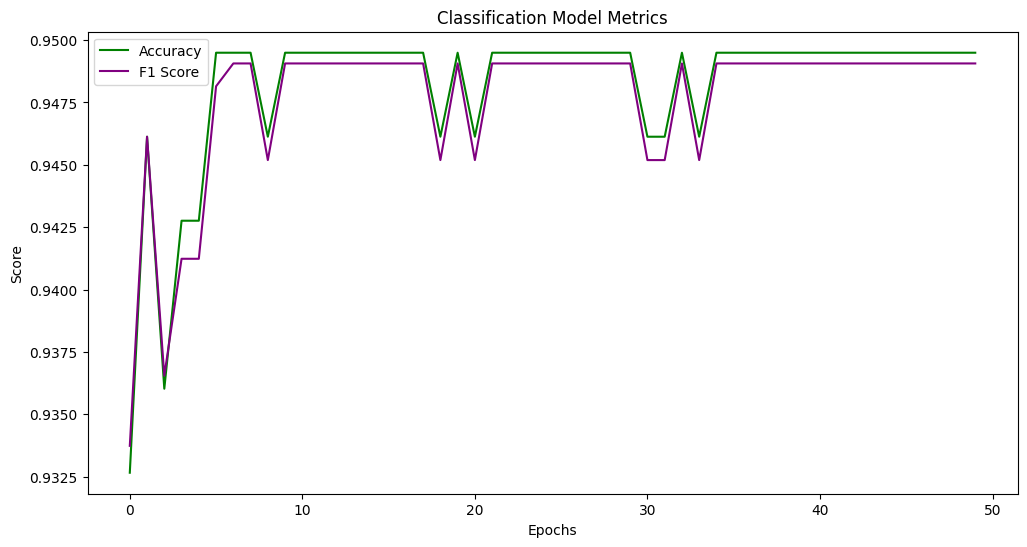

In [ ]:
# Plot classification metrics
plt.figure(figsize=(12, 6))
plt.plot(accuracy_list, label='Accuracy', color='green')
plt.plot(f1_list, label='F1 Score', color='purple')
plt.title('Classification Model Metrics')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()


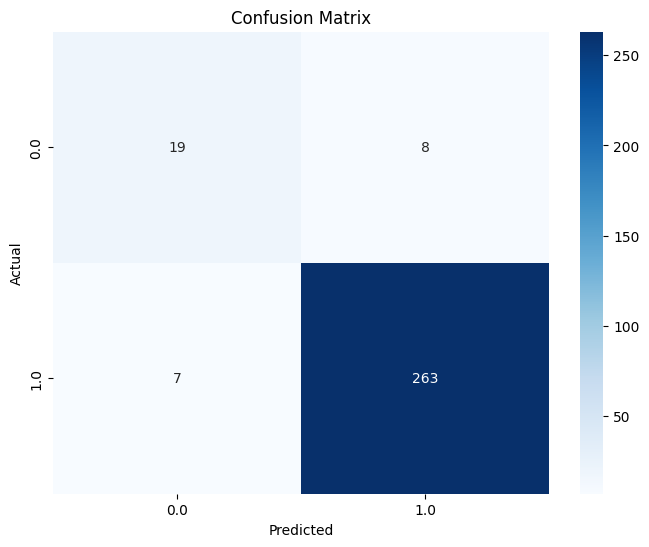

Validation Accuracy: 94.95%
F1 Score: 0.9491
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.70      0.72        27
         1.0       0.97      0.97      0.97       270

    accuracy                           0.95       297
   macro avg       0.85      0.84      0.84       297
weighted avg       0.95      0.95      0.95       297



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model to get predictions
def evaluate_model(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val)
        outputs = model(X_val_tensor)
        _, predicted = torch.max(outputs.data, 1)

    accuracy = accuracy_score(y_val, predicted)
    f1 = f1_score(y_val, predicted, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(y_val, predicted)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f'Validation Accuracy: {accuracy * 100:.2f}%')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:\n', classification_report(y_val, predicted))

# Evaluate the model on the validation set
evaluate_model(classification_model, X_val_combined, y_val_combined)


ROC-AUC Score: 0.9756


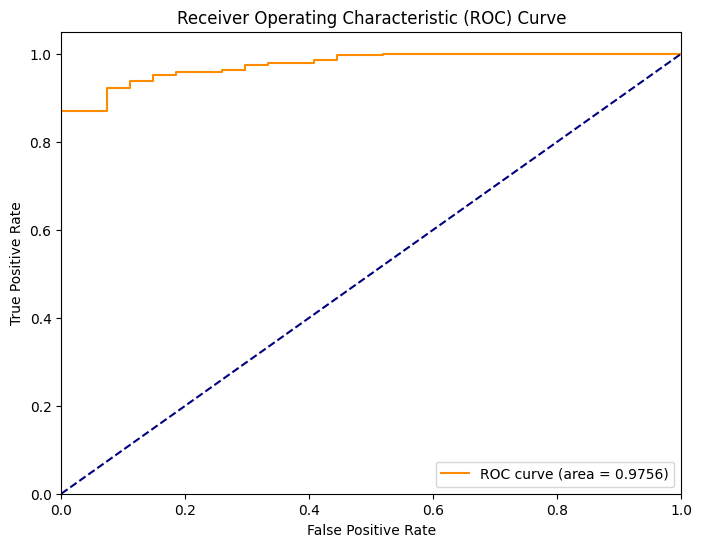

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Evaluate the model to calculate ROC-AUC
def evaluate_model_roc_auc(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val)
        outputs = model(X_val_tensor)
        probabilities = torch.softmax(outputs, dim=1)  # Get probabilities for both classes

    # Calculate ROC-AUC
    if len(np.unique(y_val)) == 2:  # Binary classification
        roc_auc = roc_auc_score(y_val, probabilities[:, 1].numpy())  # AUC for the positive class
    else:
        roc_auc = roc_auc_score(y_val, probabilities.numpy(), multi_class='ovo', average='weighted')

    print(f'ROC-AUC Score: {roc_auc:.4f}')

    # Compute ROC curve for binary classification
    if len(np.unique(y_val)) == 2:  # Binary classification
        fpr, tpr, _ = roc_curve(y_val, probabilities[:, 1].numpy())

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})', color='darkorange')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

# Evaluate the model on the validation set
evaluate_model_roc_auc(classification_model, X_val_combined, y_val_combined)


Average Precision Score: 0.9975


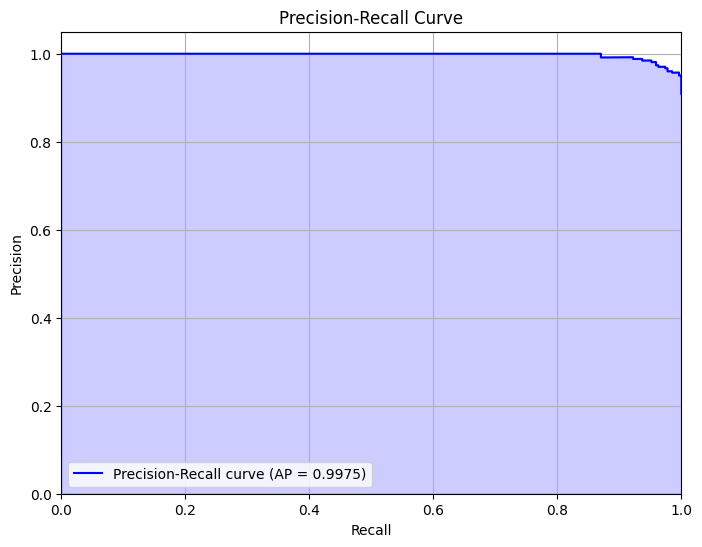

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Evaluate the model to calculate Precision-Recall Curve and Average Precision
def evaluate_model_precision_recall(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val)
        outputs = model(X_val_tensor)
        probabilities = torch.softmax(outputs, dim=1)  # Get probabilities for both classes

    # Calculate Precision-Recall curve
    if len(np.unique(y_val)) == 2:  # Binary classification
        precision, recall, _ = precision_recall_curve(y_val, probabilities[:, 1].numpy())
        average_precision = average_precision_score(y_val, probabilities[:, 1].numpy())
    else:
        # For multi-class, you can average precision scores over classes
        precision, recall, _ = precision_recall_curve(y_val.ravel(), probabilities.numpy().ravel())
        average_precision = average_precision_score(y_val, probabilities, average="weighted")

    print(f'Average Precision Score: {average_precision:.4f}')

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.4f})', color='blue')
    plt.xlabel('Recall')
    plt.fill_between(recall, precision, alpha=0.2, color='blue')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

# Evaluate the model on the validation set
evaluate_model_precision_recall(classification_model, X_val_combined, y_val_combined)


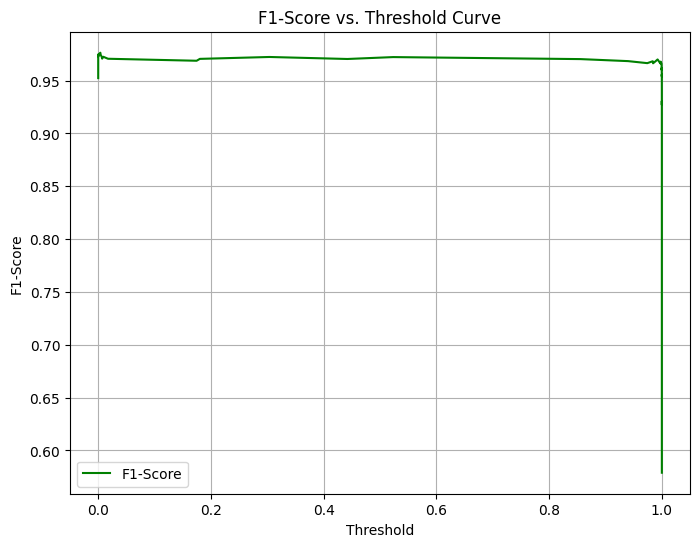

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve

# Function to compute F1-Score vs. Threshold curve
def plot_f1_vs_threshold(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val)
        outputs = model(X_val_tensor)
        probabilities = torch.softmax(outputs, dim=1)  # Get probabilities for both classes

    # Get precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_val, probabilities[:, 1].numpy())

    # Calculate F1-scores for each threshold
    f1_scores = []
    for threshold in thresholds:
        predicted = (probabilities[:, 1].numpy() >= threshold).astype(int)
        f1 = f1_score(y_val, predicted)
        f1_scores.append(f1)

    # Plot F1-score vs. Threshold curve
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores, color='green', label='F1-Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs. Threshold Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

# Evaluate the model on the validation set and plot F1-Score vs. Threshold curve
plot_f1_vs_threshold(classification_model, X_val_combined, y_val_combined)
